## ResNet-50 Architecture with Data Parallelism

The network in this notebook is an implementation of the ResNet-50 [1] architecture on the CelebA face dataset [2] to train a gender classifier.  


References
    
- [1] He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778). ([CVPR Link](https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html))

- [2] Zhang, K., Tan, L., Li, Z., & Qiao, Y. (2016). Gender and smile classification using deep convolutional neural networks. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition Workshops (pp. 34-38).

The ResNet-50 architecture is similar to the ResNet-34 architecture shown below (from [1]):


![](images/resnets/resnet34/resnet34-arch.png)

However, in ResNet-50, the skip connection uses a bottleneck (from [1]):


![](images/resnets/resnet50/resnet50-arch-1.png)


The following figure illustrates residual blocks with skip connections such that the input passed via the shortcut matches the dimensions of the main path's output, which allows the network to learn identity functions.

![](images/resnets/resnet-ex-1-1.png)


The ResNet-34 architecture actually uses residual blocks with skip connections such that the input passed via the shortcut matches is resized to dimensions of the main path's output. Such a residual block is illustrated below:

![](images/resnets/resnet-ex-1-2.png)

The ResNet-50 uses a bottleneck as shown below:

![](images/resnets/resnet-ex-1-3.png)

In [1]:
import sys
sys.path.append("/Users/ZRC")
sys.path

['',
 '/anaconda/envs/py36/lib/python36.zip',
 '/anaconda/envs/py36/lib/python3.6',
 '/anaconda/envs/py36/lib/python3.6/lib-dynload',
 '/anaconda/envs/py36/lib/python3.6/site-packages',
 '/anaconda/envs/py36/lib/python3.6/site-packages/IPython/extensions',
 '/data/home/zhangruochi/.ipython',
 '/Users/ZRC']

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler
from torch.utils.data import Subset


from torchvision import datasets
from torchvision import transforms

from torchsummary import summary

In [5]:
from coke.visualization.image import show_batch

## Model Setting

In [4]:
# Hyperparameters

BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 0.0001
RANDOM_SEED = 7

# Architecture
NUM_CLASSES = 10
GRAYSCALE = True

# other
# torch.cuda.empty_cache()
DEVICE = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")

In [5]:
data_transforms = {"train": transforms.Compose([
                            transforms.Resize((32,32)),
                            transforms.ToTensor()]),
                    "test": transforms.Compose([
                            transforms.Resize((32,32)),
                            transforms.ToTensor()])
                   }

In [6]:
train_indices = torch.arange(0, 59000)
valid_indices = torch.arange(59000, 60000)



train_and_valida_dataset = datasets.MNIST(root = "data",
                                train = True,
                                transform = data_transforms["train"],
                                download=True)

test_dataset = datasets.MNIST(root = "data",
                                train = False,
                                transform = data_transforms["test"],
                                download=False)

train_dataset = Subset(train_and_valida_dataset, train_indices)
valid_dataset = Subset(train_and_valida_dataset, valid_indices)




train_dataloader = DataLoader(dataset = train_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=4)

valid_dataloader = DataLoader(dataset = valid_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=4)

test_dataloader = DataLoader(dataset = test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=4)

data_loader = {"train": train_dataloader, 
               "val": valid_dataloader,
               "test": test_dataloader}

In [8]:
batch_samples,labels = next(iter(train_dataloader))
print(batch_samples.size(),labels.size())
show_batch(batch_samples.squeeze(), labels.numpy(), (4,4))

torch.Size([64, 1, 32, 32]) torch.Size([64])


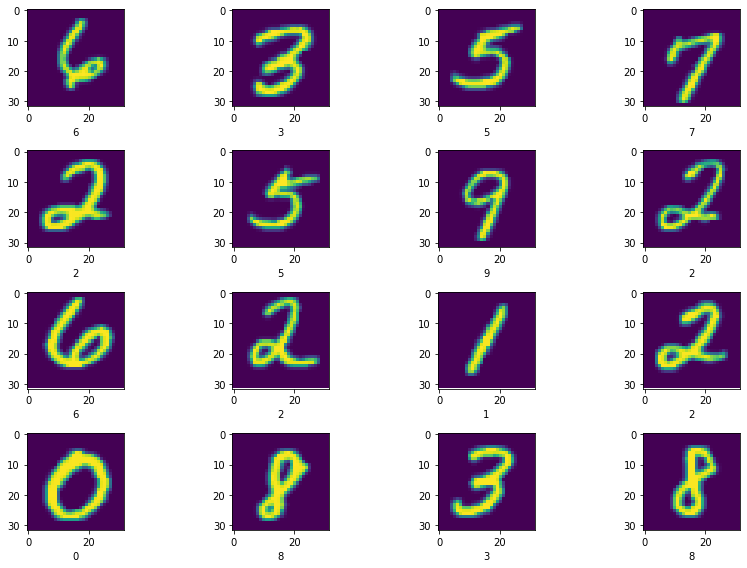

In [13]:
batch_samples,labels = next(iter(valid_dataloader))
print(batch_samples.shape,labels.shape)
show_batch(batch_samples.squeeze(), labels.numpy(), (4,4))

torch.Size([64, 1, 32, 32]) torch.Size([64])


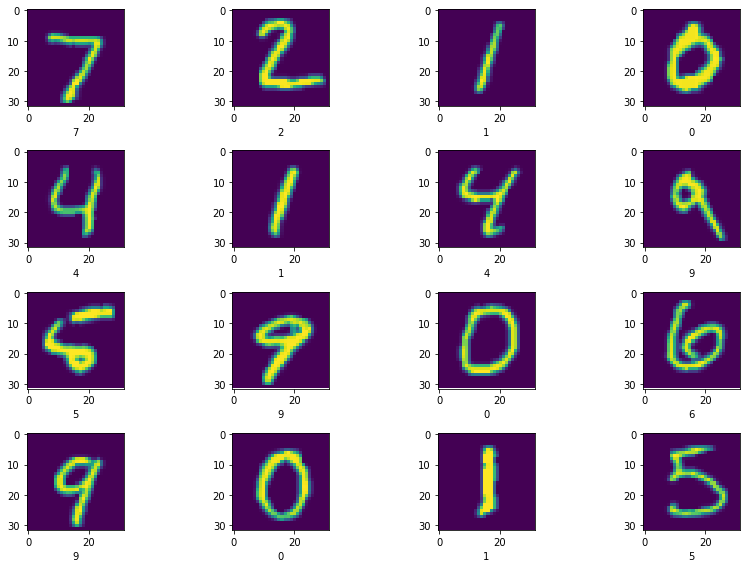

In [14]:
batch_samples,labels = next(iter(test_dataloader))
print(batch_samples.shape,labels.shape)
show_batch(batch_samples.squeeze(), labels.numpy(), (4,4))

## Model

In [9]:
def conv3x3(inplanes, outplanes, stride = 1):
    return torch.nn.Conv2d(inplanes, 
                           outplanes, 
                           stride=stride,
                           kernel_size=3, 
                           padding = 1,
                           bias=False)

In [10]:
class BasicBlock(torch.nn.Module):
    expansion = 1
    def __init__(self, inplanes, 
                 outplanes, 
                 stride = 1, 
                 downsample = None):
        
        super(BasicBlock, self).__init__()
        
        self.seq = torch.nn.Sequential(
            conv3x3(inplanes,outplanes,stride),
            torch.nn.BatchNorm2d(outplanes),
            torch.nn.ReLU(inplace = True),
            
            
            conv3x3(outplanes,outplanes),
            torch.nn.BatchNorm2d(outplanes),      
        )
                
        self.downsample = downsample
        self.stride = stride
        
        
    def forward(self, x):
        residule = x
        
        out = self.seq(x)
        
        if self.downsample is not None:
            residule = self.downsample(x)
        
        out += residule
        return F.relu(out)    

In [11]:
def test_BasicBlock():
    model = BasicBlock(64,64).to(DEVICE)
    summary(model, (64,32,32))
test_BasicBlock()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]          36,864
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
Total params: 73,984
Trainable params: 73,984
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 2.50
Params size (MB): 0.28
Estimated Total Size (MB): 3.03
----------------------------------------------------------------


In [12]:
class Bottleneck(torch.nn.Module):
    expansion = 4
    def __init__(self, inplanes, outplanes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()        
        self.seq = torch.nn.Sequential(
            # [1x1]
            torch.nn.Conv2d(inplanes, 
                            outplanes, 
                            kernel_size=1, 
                            bias=False),
            torch.nn.BatchNorm2d(outplanes),
            
            # [3x3]
            torch.nn.Conv2d(outplanes, 
                            outplanes, 
                            kernel_size=3, 
                            stride=stride,
                            padding=1, 
                            bias=False),
            torch.nn.BatchNorm2d(outplanes),
            
            # [1x1]
            torch.nn.Conv2d(outplanes, 
                                   outplanes * 4, 
                                   kernel_size=1, 
                                   bias=False),
            torch.nn.BatchNorm2d(outplanes * 4))
        
        self.downsample = downsample
        self.stride = stride
        
    def forward(self, x):
        residual = x
        
        out = self.seq(x)
        if self.downsample is not None:
            residual = self.downsample(x)
        
        out += residual
        return F.relu(out)

In [13]:
def test_Bottleneck():
    model = Bottleneck(256,64).to(DEVICE)
    summary(model, (256,28,28))
test_Bottleneck()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]          16,384
       BatchNorm2d-2           [-1, 64, 28, 28]             128
            Conv2d-3           [-1, 64, 28, 28]          36,864
       BatchNorm2d-4           [-1, 64, 28, 28]             128
            Conv2d-5          [-1, 256, 28, 28]          16,384
       BatchNorm2d-6          [-1, 256, 28, 28]             512
Total params: 70,400
Trainable params: 70,400
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.77
Forward/backward pass size (MB): 4.59
Params size (MB): 0.27
Estimated Total Size (MB): 5.63
----------------------------------------------------------------


In [14]:
class ResNetZrc(torch.nn.Module):

    def __init__(self, block, layers, grasacale = False, num_classes=1000):
        super(ResNetZrc, self).__init__()
        
        self.inplanes = 64
        
        if grasacale:
            init_channels = 1
        else:
            init_channels = 3
        
        
        self.pre = torch.nn.Sequential(OrderedDict([
            ("conv0", torch.nn.Conv2d(init_channels, 
                                      self.inplanes, 
                                      kernel_size=7, 
                                      stride=2, 
                                      padding=3,
                                      bias=False)),
            ("bn0", torch.nn.BatchNorm2d(self.inplanes)),
            ("relu0", torch.nn.ReLU(inplace=True)),
            ("pool0", torch.nn.MaxPool2d(kernel_size = 3, stride=2, padding=1))
            
        ]))
        
        
        self.middle_layers = torch.nn.Sequential(
            self._make_layers(block, 64,  layers[0]),
            self._make_layers(block, 128, layers[1], stride=2),
            self._make_layers(block, 256, layers[2], stride=2),
            self._make_layers(block, 512, layers[3], stride=2)
        )
        
        self.avgpool = torch.nn.AdaptiveAvgPool2d(1)
        self.flatten = torch.nn.Flatten()
        self.fc = torch.nn.Linear(512 * block.expansion, num_classes)
        
        
        for name, layer in self.named_modules():
            if isinstance(layer, torch.nn.Conv2d):
                n = layer.kernel_size[0] * layer.kernel_size[1] * layer.out_channels
                layer.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(layer, torch.nn.BatchNorm2d):
                layer.weight.data.fill_(1)
                layer.bias.data.zero_()
            
    
    def _make_layers(self, block, planes, multiplier, stride = 1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = torch.nn.Sequential(
                torch.nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                torch.nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, multiplier):
            layers.append(block(self.inplanes, planes))
        
        return torch.nn.Sequential(*layers)    
    
    def forward(self, x):
        x = self.pre(x)
        x = self.middle_layers(x)
        x = self.avgpool(x)
        x = self.flatten(x).squeeze()
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas
        

In [15]:
def test_ResNet34():
    model = ResNetZrc(BasicBlock, [3,4,6,3], num_classes = NUM_CLASSES).to(DEVICE)
    summary(model, (3,28,28))
test_ResNet34()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          36,864
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
       BasicBlock-10             [-1, 64, 7, 7]               0
           Conv2d-11             [-1, 64, 7, 7]          36,864
      BatchNorm2d-12             [-1, 64, 7, 7]             128
             ReLU-13             [-1, 64, 7, 7]               0
           Conv2d-14             [-1, 6

In [16]:
def test_ResNet50():
    model = ResNetZrc(Bottleneck, [3,4,6,3], num_classes = NUM_CLASSES).to(DEVICE)
    summary(model, (3,28,28))
test_ResNet50()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]           4,096
       BatchNorm2d-6             [-1, 64, 7, 7]             128
            Conv2d-7             [-1, 64, 7, 7]          36,864
       BatchNorm2d-8             [-1, 64, 7, 7]             128
            Conv2d-9            [-1, 256, 7, 7]          16,384
      BatchNorm2d-10            [-1, 256, 7, 7]             512
           Conv2d-11            [-1, 256, 7, 7]          16,384
      BatchNorm2d-12            [-1, 256, 7, 7]             512
       Bottleneck-13            [-1, 256, 7, 7]               0
           Conv2d-14             [-1, 6

In [17]:
def resnet50():
    return ResNetZrc(Bottleneck, [3,4,6,3], NUM_CLASSES)

def resnet34():
    return ResNetZrc(BasicBlock, [3,4,6,3], NUM_CLASSES)

In [18]:
model = resnet50()
model.to(DEVICE)

#### DATA PARALLEL START ####
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    model = torch.nn.DataParallel(model)
#### DATA PARALLEL END ####

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [19]:
def compute_accuracy(model, data_loader, device):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [20]:
def train_model(model, data_loader, optimizer, num_epochs,batch_size, device, metric_func, random_seed = 7):
    # Manual seed for deterministic data loader
    torch.manual_seed(random_seed)
    
    loss_list = []
    train_acc_list, valid_acc_list = [], []
    
    for epoch in range(num_epochs):
        # set training mode
        model.train() 
        for batch_idx, (features, targets) in enumerate(data_loader["train"]):
            features = features.to(device)
            targets = targets.to(device)


            ## forward pass
            logits, probas = model(features)
            loss = F.cross_entropy(logits,targets)

            # backward pass
            # clear the gradients of all tensors being optimized
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ### Login
            loss_list.append(loss.item())
            if not batch_idx % 50:
                print ('Epoch: {0:03d}/{1:03d} | Batch {2:03d}/{3:03d} | Loss: {4:.2f}'.format(
                    epoch+1, num_epochs, batch_idx, 
                         len(train_dataset)//batch_size, loss))

        with torch.set_grad_enabled(False):
            train_acc = metric_func(model, data_loader["train"], device)
            valid_acc = metric_func(model, data_loader["val"], device)
            
            print('Epoch: {0:03d}/{1:03d} training accuracy: {2:.2f}'.format(
                  epoch+1, num_epochs, train_acc))
            
            print('Epoch: {0:03d}/{1:03d} validation accuracy: {2:.2f}'.format(
                  epoch+1, num_epochs, valid_acc))
            
            train_acc_list.append(train_acc)
            valid_acc_list.append(valid_acc)
            
    return loss_list, train_acc_list, valid_acc_list

In [21]:
loss_list, train_acc_list, valid_acc_list = train_model(
                    model, 
                    data_loader, 
                    optimizer, 
                    NUM_EPOCHS, 
                    device = DEVICE, 
                    batch_size = BATCH_SIZE,
                    metric_func = compute_accuracy)

Epoch: 001/010 | Batch 000/921 | Loss: 7.48
Epoch: 001/010 | Batch 050/921 | Loss: 0.37
Epoch: 001/010 | Batch 100/921 | Loss: 0.09
Epoch: 001/010 | Batch 150/921 | Loss: 0.18
Epoch: 001/010 | Batch 200/921 | Loss: 0.15
Epoch: 001/010 | Batch 250/921 | Loss: 0.05
Epoch: 001/010 | Batch 300/921 | Loss: 0.16
Epoch: 001/010 | Batch 350/921 | Loss: 0.03
Epoch: 001/010 | Batch 400/921 | Loss: 0.08
Epoch: 001/010 | Batch 450/921 | Loss: 0.04
Epoch: 001/010 | Batch 500/921 | Loss: 0.14
Epoch: 001/010 | Batch 550/921 | Loss: 0.05
Epoch: 001/010 | Batch 600/921 | Loss: 0.06
Epoch: 001/010 | Batch 650/921 | Loss: 0.10
Epoch: 001/010 | Batch 700/921 | Loss: 0.14
Epoch: 001/010 | Batch 750/921 | Loss: 0.14
Epoch: 001/010 | Batch 800/921 | Loss: 0.08
Epoch: 001/010 | Batch 850/921 | Loss: 0.11
Epoch: 001/010 | Batch 900/921 | Loss: 0.03
Epoch: 001/010 training accuracy: 98.72
Epoch: 001/010 validation accuracy: 98.80
Epoch: 002/010 | Batch 000/921 | Loss: 0.10
Epoch: 002/010 | Batch 050/921 | Loss:

Epoch: 010/010 | Batch 000/921 | Loss: 0.01
Epoch: 010/010 | Batch 050/921 | Loss: 0.01
Epoch: 010/010 | Batch 100/921 | Loss: 0.00
Epoch: 010/010 | Batch 150/921 | Loss: 0.05
Epoch: 010/010 | Batch 200/921 | Loss: 0.00
Epoch: 010/010 | Batch 250/921 | Loss: 0.00
Epoch: 010/010 | Batch 300/921 | Loss: 0.00
Epoch: 010/010 | Batch 350/921 | Loss: 0.00
Epoch: 010/010 | Batch 400/921 | Loss: 0.00
Epoch: 010/010 | Batch 450/921 | Loss: 0.01
Epoch: 010/010 | Batch 500/921 | Loss: 0.04
Epoch: 010/010 | Batch 550/921 | Loss: 0.01
Epoch: 010/010 | Batch 600/921 | Loss: 0.02
Epoch: 010/010 | Batch 650/921 | Loss: 0.00
Epoch: 010/010 | Batch 700/921 | Loss: 0.00
Epoch: 010/010 | Batch 750/921 | Loss: 0.00
Epoch: 010/010 | Batch 800/921 | Loss: 0.01
Epoch: 010/010 | Batch 850/921 | Loss: 0.01
Epoch: 010/010 | Batch 900/921 | Loss: 0.02
Epoch: 010/010 training accuracy: 99.67
Epoch: 010/010 validation accuracy: 99.10


In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

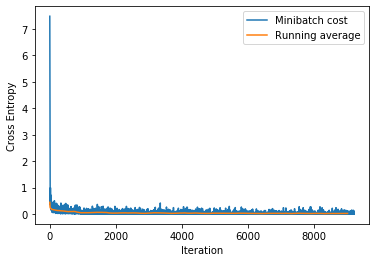

In [23]:
plt.plot(loss_list, label='Minibatch cost')
plt.plot(np.convolve(loss_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

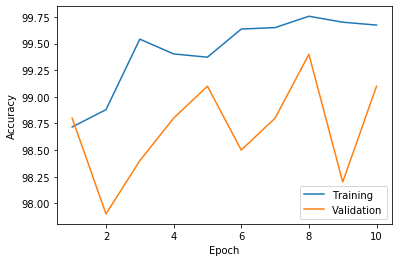

In [24]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [25]:
with torch.set_grad_enabled(False):
    test_acc = compute_accuracy(model=model,
                           data_loader=data_loader["test"],
                           device=DEVICE)
    
    valid_acc = compute_accuracy(model=model,
                            data_loader=data_loader["val"],
                            device=DEVICE)
    

print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')

Validation ACC: 99.10%
Test ACC: 98.94%
